In [2]:
# import packages

import numpy as np
import pandas as pd
import pickle


import os
#import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras

import datetime
import matplotlib.pyplot as plt
import preprocessor as p

from utils.embed_utils import read_glove_vecs

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import re
import string

In [3]:
def load_data(train_or_test):
    if train_or_test not in ['train', 'test']:
        return None
    path = 'data\CombinedTWTAQ_' + train_or_test + '.pkl'
    with open(path, 'rb') as infile:
        df = pickle.load(infile)
    return df

def clean_text(text):
    '''
    lowercase, remove puncs, remove urls
    '''
    return p.clean(text)
    
clean = lambda x: clean_text(x)

def df_to_xy(df):
    x_text = df.text.apply(lambda x: x).values
    #x_price = df.PP.apply(lambda xx: xx[:60]).values
    y = df.PP.apply(lambda xx: xx[75]).values
    #y = y.values
    return (x_text,y)

In [4]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [5]:
df_train = load_data('train')
(x,y) = df_to_xy(df_train)


In [8]:
embed = hub.Module(module_url)

tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as sess:
  sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
  embeddings = sess.run(embed(x))

In [9]:
#x_train, x_dev, y_train, y_dev = train_test_split(x,y, test_size=200, random_state=50)

x_train, x_dev, y_train, y_dev = train_test_split(embeddings,y, test_size=200, random_state=50)


In [10]:
embeddings.shape

(1345, 512)

In [11]:
type(embeddings)

numpy.ndarray

In [12]:
x_train.shape

(1145, 512)

In [13]:
def create_model_use(embed_size=512):
    
    input_embed = keras.layers.Input(shape=(embed_size,), dtype=tf.float32)
    X = keras.layers.Dropout(0.5)(input_embed)
    X = keras.layers.Dense(4, activation='sigmoid',kernel_regularizer=keras.regularizers.l2(0.01))(X)
    X = keras.layers.Dropout(0.2)(X)
    out = keras.layers.Dense(1, activation='linear')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = keras.models.Model(inputs=input_embed, outputs=out)
    
    return model

In [14]:

tf.reset_default_graph()
model = create_model_use()
model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

model.fit(x_train, y_train, epochs=200)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 2,057
Trainable params: 2,057
Non-trainable params: 0
_________________________________________________________________
Train on 1145 samples
Epoch 1/200
1145/1145 [==============================] - 0s 150us/sample - loss: 0.4555 - mean_squared_

1145/1145 [==============================] - 0s 41us/sample - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.0930
Epoch 105/200
1145/1145 [==============================] - 0s 55us/sample - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.0942
Epoch 106/200
1145/1145 [==============================] - 0s 41us/sample - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.0928
Epoch 107/200
1145/1145 [==============================] - 0s 41us/sample - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.0937
Epoch 108/200
1145/1145 [==============================] - 0s 41us/sample - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.0929
Epoch 109/200
1145/1145 [==============================] - 0s 41us/sample - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.0930
Epoch 110/200
1145/1145 [==============================] - 0s 41us/sample - loss: 0.0228 - mean_squared_error: 0.0228 - mean_a

In [15]:
print( np.sqrt( mean_squared_error(y_train, model.predict(x_train)) ) )
print( np.sqrt( mean_squared_error(y_dev, model.predict(x_dev)) ) )

0.15092850222728835
0.15203871075994516


In [16]:
print( np.sqrt( mean_squared_error(y_train, 0*y_train) ) )
print( np.sqrt( mean_squared_error(y_dev, 0*y_dev) ) )

0.15128836169147417
0.15246748337145208


## Conclusion


Guess 0:
- Train error: 15.13
- Dev error: 15.25
- Test error: 15.26

LSTM model with twitter embedding:
- Train error: 14.95
- Dev error: 15.21
- Test error: 15.40

USE model:
- Train error: 15.09
- Dev error 15.20
- Test error: 15.31

In [17]:
# save model
savepath = 'MODEL_USE_embed.h5'
model.save(savepath)

In [7]:
load_path = 'MODEL_USE_embed.h5'
model = keras.models.load_model(load_path)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 2,057
Trainable params: 2,057
Non-trainable params: 0
_________________________________________________________________


In [8]:
df_test = load_data('test')

x_test, y_test = df_to_xy(df_test)

embed = hub.Module(module_url)

#tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as sess:
  sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
  embeddings_test = sess.run(embed(x_test))

y_test_hat = model.predict(embeddings_test)


print( np.sqrt( mean_squared_error(y_test, y_test_hat) ) )

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


0.15306900001031926


In [9]:
print( np.sqrt( mean_squared_error(y_test, y_test_hat) ) )
print( np.sqrt( mean_squared_error(y_test, 0*y_test) ) )

0.15306900001031926
0.15264363624391106


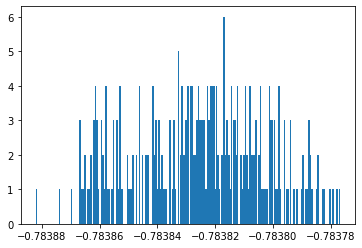

In [11]:
plt.figure()
plt.hist(100*y_test_hat,201)
plt.show()

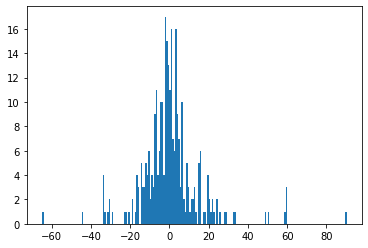

In [12]:
plt.figure()
plt.hist(100*y_test,201)
plt.show()